In [141]:
import timeit
import logging
from tqdm import tqdm
import arviz as az
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import pytensor as pyt
from random import randint
from prophet import Prophet
from sklearn.metrics import (
    mean_squared_error,
    root_mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
import yfinance
from abc import ABC, abstractmethod

logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled=True

# Fetch data

In [881]:
data = yfinance.download(
    ["^GSPC", "MSFT", "AAPL", "GOOG"],
    interval="1d",
    start="2005-01-01",
    end="2010-01-01",
)
data

[*********************100%***********************]  4 of 4 completed


Price      Adj Close                                        Close             \
Ticker          AAPL       GOOG       MSFT        ^GSPC      AAPL       GOOG   
Date                                                                           
2005-01-03  0.953359   5.030750  18.556292  1202.079956  1.130179   5.048826   
2005-01-04  0.963151   4.826998  18.625677  1188.050049  1.141786   4.844342   
2005-01-05  0.971586   4.802429  18.584051  1183.739990  1.151786   4.819685   
2005-01-06  0.972339   4.679335  18.563234  1187.890015  1.152679   4.696148   
2005-01-07  1.043136   4.810867  18.507713  1186.189941  1.236607   4.828153   
...              ...        ...        ...          ...       ...        ...   
2009-12-24  6.297681  15.349110  23.338324  1126.479980  7.465714  15.404261   
2009-12-28  6.375108  15.458059  23.466307  1127.780029  7.557500  15.513601   
2009-12-29  6.299491  15.371943  23.631929  1126.199951  7.467857  15.427175   
2009-12-30  6.376011  15.454584  23.308212  1126.420044  7.558571  15.510114   
2009-12-31  6.348595  15.386335  22.946835  1115.099976  7.526071  15.441621   

Price                                   High             ...        Low  \
Ticker           MSFT        ^GSPC      AAPL       GOOG  ...       MSFT   
Date                                                     ...              
2005-01-03  26.740000  1202.079956  1.162679   5.071989  ...  26.650000   
2005-01-04  26.840000  1188.050049  1.169107   5.054305  ...  26.660000   
2005-01-05  26.780001  1183.739990  1.165179   4.904118  ...  26.760000   
2005-01-06  26.750000  1187.890015  1.159107   4.879212  ...  26.639999   
2005-01-07  26.670000  1186.189941  1.243393   4.838116  ...  26.620001   
...               ...          ...       ...        ...  ...        ...   
2009-12-24  31.000000  1126.479980  7.476786  15.430164  ...  30.760000   
2009-12-28  31.170000  1127.780029  7.641071  15.591310  ...  30.889999   
2009-12-29  31.389999  1126.199951  7.597143  15.562667  ...  31.230000   
2009-12-30  30.959999  1126.420044  7.571429  15.510114  ...  30.799999   
2009-12-31  30.480000  1115.099976  7.619643  15.576615  ...  30.480000   

Price                        Open                                     \
Ticker            ^GSPC      AAPL       GOOG       MSFT        ^GSPC   
Date                                                                   
2005-01-03  1200.319946  1.156786   4.916571  26.799999  1211.920044   
2005-01-04  1185.390015  1.139107   5.016198  26.870001  1202.079956   
2005-01-05  1183.719971  1.151071   4.818190  26.840000  1188.050049   
2005-01-06  1183.270020  1.154821   4.858788  26.850000  1183.739990   
2005-01-07  1182.160034  1.160714   4.748203  26.820000  1187.890015   
...                 ...       ...        ...        ...          ...   
2009-12-24  1121.079956  7.269643  15.266029  30.879999  1121.079956   
2009-12-28  1123.510010  7.561429  15.483464  31.000000  1127.530029   
2009-12-29  1126.079956  7.593929  15.560177  31.350000  1128.550049   
2009-12-30  1121.939941  7.458214  15.404759  31.150000  1125.530029   
2009-12-31  1114.810059  7.611786  15.560426  30.980000  1126.599976   

Price           Volume                                    
Ticker            AAPL       GOOG       MSFT       ^GSPC  
Date                                                      
2005-01-03   691992000  636143518   65002900  1510800000  
2005-01-04  1096810400  552298420  109442100  1721000000  
2005-01-05   680433600  330698912   72463500  1738900000  
2005-01-06   705555200  417041336   76890500  1569100000  
2005-01-07  2227450400  387964757   68723300  1477900000  
...                ...        ...        ...         ...  
2009-12-24   500889200   34476745   11083900  1267710000  
2009-12-28   644565600   68170566   25384000  2716400000  
2009-12-29   445205600   57205620   29716200  2491020000  
2009-12-30   412084400   58843737   42006200  2277300000  
2009-12-31   352410800   48974884   31929700  207699

In [889]:
dfs = []
for ticker in ["^GSPC", "MSFT", "GOOG", "AAPL"]:
    df = pd.DataFrame(
        data={
            "open": data["Open"][ticker].to_numpy(),
            "high": data["High"][ticker].to_numpy(),
            "low": data["Low"][ticker].to_numpy(),
            "close": data["Adj Close"][ticker].to_numpy(),
            "typical_price": ((data["Open"][ticker] + data["High"][ticker] + data["Low"][ticker] + data["Close"][ticker]) / 4).to_numpy(),
        }, 
        index=data["Adj Close"][ticker].index
    )
    
    full_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
    df = df.reindex(full_date_range).interpolate()
    df["ds"] = df.index
    df.reset_index(drop=True, inplace=True)
    df["series"] = ticker
    dfs.append(df)

# Model

In [907]:
def get_group_definition(X, pool_cols, pool_type):
    if pool_type == "complete":
        group = np.zeros(len(X), dtype="int")
        group_mapping = {0: "all"}
        n_groups = 1
    else:
        X[pool_cols] = pd.Categorical(X[pool_cols])
        group = X[pool_cols].cat.codes.values
        group_mapping = dict(enumerate(X[pool_cols].cat.categories))
        n_groups = X[pool_cols].nunique()
    return group, n_groups, group_mapping


class TimeSeriesModel:
    def _scale_data(self):
        self.y_min = 0
        self.y_max = self.data["y"].abs().max()
        self.ds_min = self.data["ds"].min()
        self.ds_max = self.data["ds"].max()

        self.data["y"] = self.data["y"] / self.y_max
        self.data["t"] = (self.data["ds"] - self.ds_min) / (self.ds_max - self.ds_min)

    def _process_data(self):
        self.data["ds"] = pd.to_datetime(self.data["ds"])
        self.data.sort_values("ds", inplace=True)
        self._scale_data()

    def _model_init(self):
        i0, i1 = self.data["ds"].idxmin(), self.data["ds"].idxmax()
        T = self.data["t"].iloc[i1] - self.data["t"].iloc[i0]
        slope = (self.data["y"].iloc[i1] - self.data["y"].iloc[i0]) / T
        intercept = self.data["y"].iloc[i0] - slope * self.data["t"].iloc[i0]
        return {
            "slope": slope,
            "intercept": intercept,
            "delta": 0.0,
            "beta": 0.0,
            "sigma": 1.0,
        }

    def fit(
        self,
        data,
        sigma_sd=0.5,
        mcmc_samples=0,
        chains=4,
        cores=4,
        use_prophet_initvals=True,
    ):
        self.mcmc_samples = mcmc_samples

        self.data = data.reset_index(drop=True)
        self._process_data()

        self.initvals = {}
        # if use_prophet_initvals:
        #     self.initvals = self._model_init()

        self.model = pm.Model()
        self.model_idxs = {}
        mu = self.definition(self.model, self.data, self.initvals, self.model_idxs)

        with self.model:
            sigma = pm.HalfNormal(
                "sigma", sigma_sd, initval=self.initvals.get("sigma", 1)
            )
            obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=self.data["y"])

            self.map_approx = None
            self.trace = None
            if self.mcmc_samples == 0:
                self.map_approx = pm.find_MAP(progressbar=True, maxeval=1e4)
            else:
                self.trace = pm.sample(self.mcmc_samples, chains=chains, cores=cores)

    def _make_future_df(self, days):
        future = pd.DataFrame(
            {
                "ds": pd.DatetimeIndex(
                    pd.concat(
                        (
                            self.data["ds"],
                            pd.date_range(
                                self.ds_max,
                                self.ds_max + pd.Timedelta(days, "D"),
                                inclusive="right",
                            ).to_series(),
                        )
                    )
                )
            }
        )
        future["t"] = (future["ds"] - self.ds_min) / (self.ds_max - self.ds_min)
        return future

    def predict(self, days):
        future = self._make_future_df(days)
        forecasts = self._predict(future, self.mcmc_samples, self.map_approx, self.trace)
        
        for group_code in range(forecasts.shape[0]):
            future[f"yhat_{group_code}"] = forecasts[group_code] * self.y_max
            for model_type, model_cnt in self.model_idxs.items():
                if model_type.startswith("fs"):
                    continue
                for model_idx in range(model_cnt):
                    future[f"{model_type}_{model_idx}_{group_code}"] *= self.y_max

        return future

    def _predict(self, future, mcmc_samples, map_approx, trace):
        if mcmc_samples == 0:
            return self._predict_map(future, map_approx)

        return self._predict_mcmc(future, trace)

    def plot(self, future, y_true=None, pool_cols=None):
        date = future["ds"]
        plt.figure(figsize=(14, 100 * 6))
        plt.subplot(100, 1, 1)
        plt.title("Predictions")
        plt.grid()
        
        group, n_groups, groups_ = get_group_definition(self.data, pool_cols, "partial")
        print(groups_)
        for group_code, group_name in groups_.items():
            print(group_code)
            group_idx = (group == group_code)
            color = np.random.rand(3)
            plt.scatter(
                date[:len(self.data)][group_idx], self.data["y"][group_idx] * self.y_max, s=2, color=color, label=group_name
            )
            
        if y_true is not None:
            plt.scatter(date[len(self.data) :], y_true, s=0.5, color="green", label="y")

        for group_code, group_name in groups_.items():
            plt.plot(date, future[f"yhat_{group_code}"], lw=1, label=f"yhat - {group_name}")

        plt.legend()
        plot_params = {"idx": 1}
        self._plot(plot_params, future, self.data, self.y_max, y_true)

    def __add__(self, other):
        return AdditiveTimeSeries(self, other)

    def __mul__(self, other):
        return MultiplicativeTimeSeries(self, other)


class AdditiveTimeSeries(TimeSeriesModel):
    def __init__(self, left, right):
        self.left = left
        self.right = right

    def definition(self, *args, **kwargs):
        return self.left.definition(*args, **kwargs) + self.right.definition(
            *args, **kwargs
        )

    def _predict(self, *args, **kwargs):
        return self.left._predict(*args, **kwargs) + self.right._predict(
            *args, **kwargs
        )

    def _plot(self, *args, **kwargs):
        self.left._plot(*args, **kwargs)
        self.right._plot(*args, **kwargs)


class MultiplicativeTimeSeries(TimeSeriesModel):
    def __init__(self, left, right):
        self.left = left
        self.right = right

    def definition(self, *args, **kwargs):
        return self.left.definition(*args, **kwargs) * (
            1 + self.right.definition(*args, **kwargs)
        )

    def _predict(self, *args, **kwargs):
        return self.left._predict(*args, **kwargs) * (
            1 + self.right._predict(*args, **kwargs)
        )

    def _plot(self, *args, **kwargs):
        self.left._plot(*args, **kwargs)
        self.right._plot(*args, **kwargs)


class LinearTrend(TimeSeriesModel):
    def __init__(
        self,
        n_changepoints=25,
        changepoint_range=0.8,
        slope_mean=0,
        slope_sd=5,
        intercept_mean=0,
        intercept_sd=5,
        delta_mean=0,
        delta_sd=0.05,
        pool_cols=None,
        pool_type="complete",
    ):
        self.n_changepoints = n_changepoints
        self.changepoint_range = changepoint_range
        self.slope_mean = slope_mean
        self.slope_sd = slope_sd
        self.intercept_mean = intercept_mean
        self.intercept_sd = intercept_sd
        self.delta_mean = delta_mean
        self.delta_sd = delta_sd

        self.pool_cols = pool_cols
        self.pool_type = pool_type

    def definition(self, model, data, initvals, model_idxs):
        model_idxs["lt"] = model_idxs.get("lt", 0)
        self.model_idx = model_idxs["lt"]
        model_idxs["lt"] += 1

        group, n_groups, self.groups_ = get_group_definition(
            data, self.pool_cols, self.pool_type
        )

        t = np.array(data["t"])
        hist_size = int(np.floor(data.shape[0] * self.changepoint_range))
        cp_indexes = (
            np.linspace(0, hist_size - 1, self.n_changepoints + 1).round().astype(int)
        )
        self.s = np.array(data.iloc[cp_indexes]["t"].tail(-1))

        # * 1 casts the boolean to integers
        A = (t[:, None] > self.s) * 1

        with model:
            slope = pm.Normal(
                f"lt_{self.model_idx} - slope",
                self.slope_mean,
                self.slope_sd,
                initval=initvals.get("slope", None),
                shape=n_groups,
            )

            delta_sd = self.delta_sd
            if self.delta_sd is None:
                delta_sd = pm.Exponential(f"lt_{self.model_idx} - tau", 1.5)

            delta = pm.Laplace(
                f"lt_{self.model_idx} - delta",
                self.delta_mean,
                delta_sd,
                shape=(n_groups, self.n_changepoints),
            )

            intercept = pm.Normal(
                f"lt_{self.model_idx} - intercept",
                self.intercept_mean,
                self.intercept_sd,
                initval=initvals.get("intercept", None),
                shape=n_groups,
            )

            gamma = -self.s * delta[group, :]

            trend = pm.Deterministic(
                f"lt_{self.model_idx} - trend",
                (slope[group] + pm.math.sum(A * delta[group], axis=1)) * t
                + (intercept[group] + pm.math.sum(A * gamma, axis=1)),
            )

        return trend

    def _predict_map(self, future, map_approx):
        forecasts = []
        new_A = (np.array(future["t"])[:, None] > self.s) * 1

        for group_code in self.groups_.keys():
            forecasts.append(
                np.array(
                    (
                        map_approx[f"lt_{self.model_idx} - slope"][group_code]
                        + np.dot(
                            new_A,
                            map_approx[f"lt_{self.model_idx} - delta"][group_code],
                        )
                    )
                    * future["t"]
                    + (
                        map_approx[f"lt_{self.model_idx} - intercept"][group_code]
                        + np.dot(
                            new_A,
                            (
                                -self.s
                                * map_approx[f"lt_{self.model_idx} - delta"][group_code]
                            ),
                        )
                    )
                )
            )
            future[f"lt_{self.model_idx}_{group_code}"] = forecasts[-1]

        return np.vstack(forecasts)

    def _predict_mcmc(self, future, trace):
        forecasts = []
        new_A = (np.array(future["t"])[:, None] > self.s) * 1

        for group_code in self.groups_.keys():
            delta = (
                trace["posterior"][f"lt_{self.model_idx} - delta"]
                .to_numpy()[:, :, group_code]
                .mean(0)
            )
            slope = (
                trace["posterior"][f"lt_{self.model_idx} - slope"]
                .to_numpy()[:, :, group_code]
                .mean(0)
            )
            intercept = (
                trace["posterior"][f"lt_{self.model_idx} - intercept"]
                .to_numpy()[:, :, group_code]
                .mean(0)
            )

            forecasts.append(
                (
                    (slope + np.dot(new_A, delta.T)).T * future["t"].to_numpy()
                    + (intercept + np.dot(new_A, (-self.s * delta).T)).T
                ).mean(0)
            )
            future[f"lt_{self.model_idx}_{group_code}"] = forecasts[-1]

        return np.vstack(forecasts)

    def _plot(self, plot_params, future, data, y_max, y_true=None):
        date = future["ds"]
        plot_params["idx"] += 1
        plt.subplot(100, 1, plot_params["idx"])
        plt.title(f"lt_{self.model_idx}")
        plt.grid()
        # plt.scatter(date[:len(data)], data["y"] * y_max, s=0.5, color="black")

        # if y_true is not None:
        #     plt.scatter(date[len(data):], y_true, s=0.5, color="green")
        for group_code, group_name in self.groups_.items():
            plt.plot(date, future[f"lt_{self.model_idx}_{group_code}"], lw=1)


class FourierSeasonality(TimeSeriesModel):
    def __init__(
        self,
        period,
        series_order,
        beta_mean=0,
        beta_sd=10,
        pool_cols=None,
        pool_type="complete",
    ):
        self.period = period
        self.series_order = series_order
        self.beta_mean = beta_mean
        self.beta_sd = beta_sd

        self.pool_cols = pool_cols
        self.pool_type = pool_type

    def _fourier_series(self, data):
        # convert to days since epoch
        NANOSECONDS_TO_SECONDS = 1000 * 1000 * 1000
        t = (
            data["ds"].to_numpy(dtype=np.int64)
            // NANOSECONDS_TO_SECONDS
            / (3600 * 24.0)
        )

        x_T = t * np.pi * 2
        fourier_components = np.empty((data["ds"].shape[0], 2 * self.series_order))
        for i in range(self.series_order):
            c = x_T * (i + 1) / self.period
            fourier_components[:, 2 * i] = np.sin(c)
            fourier_components[:, (2 * i) + 1] = np.cos(c)

        return fourier_components

    def definition(self, model, data, initvals, model_idxs):
        model_idxs["fs"] = model_idxs.get("fs", 0)
        self.model_idx = model_idxs["fs"]
        model_idxs["fs"] += 1

        group, n_groups, self.groups_ = get_group_definition(
            data, self.pool_cols, self.pool_type
        )

        x = self._fourier_series(data)
        beta_initval = initvals.get("beta", None)
        if beta_initval is not None:
            beta_initval = np.array([beta_initval] * 2 * self.series_order)

        with model:
            beta = pm.Normal(
                f"fs_{self.model_idx} - beta(p={self.period},n={self.series_order})",
                mu=self.beta_mean,
                sigma=self.beta_sd,
                shape=(n_groups, 2 * self.series_order),
                initval=beta_initval,
            )
        return pm.math.sum(x * beta[group], axis=1)

    def _det_seasonality_posterior(self, beta, x):
        return np.dot(x, beta.T)

    def _predict_map(self, future, map_approx):
        forecasts = []
        for group_code in self.groups_.keys():
            forecasts.append(
                self._det_seasonality_posterior(
                    map_approx[
                        f"fs_{self.model_idx} - beta(p={self.period},n={self.series_order})"
                    ][group_code],
                    self._fourier_series(future),
                )
            )
            future[f"fs_{self.model_idx}_{group_code}"] = forecasts[-1]

        return np.vstack(forecasts)

    def _predict_mcmc(self, future, trace):
        forecasts = []
        for group_code in self.groups_.keys():
            forecasts.append(
                self._det_seasonality_posterior(
                    trace["posterior"][
                        f"fs_{self.model_idx} - beta(p={self.period},n={self.series_order})"
                    ]
                    .to_numpy()[:, :, group_code]
                    .mean(0),
                    self._fourier_series(future),
                ).T.mean(0)
            )
            future[f"fs_{self.model_idx}_{group_code}"] = forecasts[-1]

        return np.vstack(forecasts)

    def _plot(self, plot_params, future, data, y_max, y_true=None):
        date = future["ds"] if self.period > 7 else future["ds"].dt.day_name()
        plot_params["idx"] += 1
        plt.subplot(100, 1, plot_params["idx"])
        plt.title(f"fs_{self.model_idx} - p={self.period},n={self.series_order}")
        plt.grid()
        # plt.scatter(date[:len(data)], data["y"] * y_max, s=0.5, color="black")

        # if y_true is not None:
        # plt.scatter(date[len(data):], y_true, s=0.5, color="green")
        print(date[: int(self.period)])
        for group_code, group_name in self.groups_.items():
            plt.plot(
                date[: int(self.period)],
                future[f"fs_{self.model_idx}_{group_code}"][: int(self.period)],
                lw=1,
            )


# Experiments

In [892]:
start = 100
window = 730
horizon = 365

train_df1 = dfs[0][start:start + window].copy()
train_df1["y"] = train_df1["typical_price"] / train_df1["typical_price"].max()
train_df2 = dfs[1][start:start + window].copy()
train_df2["y"] = train_df2["typical_price"] / train_df2["typical_price"].max()
train_df = pd.concat([train_df1, train_df2])
train_df

,open,high,low,close,typical_price,ds,series,y
100,1187.760010,1187.760010,1171.400024,1173.790039,1180.177521,2005-04-13,^GSPC,0.809887
101,1173.790039,1174.670044,1161.699951,1162.050049,1168.052521,2005-04-14,^GSPC,0.801566
102,1162.050049,1162.050049,1141.920044,1142.619995,1152.160034,2005-04-15,^GSPC,0.790660
103,1155.573364,1157.673381,1141.213379,1143.739990,1149.550028,2005-04-16,^GSPC,0.788869
104,1149.096680,1153.296712,1140.506714,1144.859985,1146.940023,2005-04-17,^GSPC,0.787078
...,...,...,...,...,...,...,...,...
825,28.515000,28.702499,28.367499,20.425654,28.537500,2007-04-08,MSFT,0.913931
826,28.580000,28.719999,28.389999,20.429232,28.565000,2007-04-09,MSFT,0.914812
827,28.500000,28.639999,28.219999,20.307674,28.440000,2007-04-10,MSFT,0.910809
828,28.299999,28.570000,27.990000,20.100300,28.242500,2007-04-11,MSFT,0.904484


In [893]:
test_df1 = dfs[0][start + window:start + window + horizon].copy()
test_df1["y"] = test_df1["typical_price"] / train_df1["typical_price"].max()
test_df2 = dfs[1][start + window:start + window + horizon].copy()
test_df2["y"] = test_df2["typical_price"] / train_df2["typical_price"].max()
test_df = pd.concat([test_df1, test_df2])
test_df

,open,high,low,close,typical_price,ds,series,y
830,1447.800049,1453.109985,1444.150024,1452.849976,1449.477509,2007-04-13,^GSPC,0.994692
831,1449.480021,1458.279989,1447.046672,1458.009969,1453.204163,2007-04-14,^GSPC,0.997249
832,1451.159993,1463.449992,1449.943319,1463.169963,1456.930817,2007-04-15,^GSPC,0.999807
833,1452.839966,1468.619995,1452.839966,1468.329956,1460.657471,2007-04-16,^GSPC,1.002364
834,1468.469971,1474.349976,1467.150024,1471.479980,1470.362488,2007-04-17,^GSPC,1.009024
...,...,...,...,...,...,...,...,...
1190,29.549999,29.590000,29.030001,21.143219,29.332500,2008-04-07,MSFT,0.939392
1191,28.940001,29.000000,28.540001,20.845940,28.807500,2008-04-08,MSFT,0.922578
1192,28.719999,29.040001,28.540001,20.947451,28.797500,2008-04-09,MSFT,0.922258
1193,28.830000,29.400000,28.799999,21.106968,29.035000,2008-04-10,MSFT,0.929864


In [908]:
lt = LinearTrend(pool_cols="series", pool_type="partial", n_changepoints=5)
ft1 = FourierSeasonality(365.25, 10, pool_cols="series", pool_type="partial")
ft2 = FourierSeasonality(7, 3, pool_cols="series", pool_type="partial")
model = lt + (ft1 + ft2)
model.fit(train_df, use_prophet_initvals=False)
yhat = model.predict(horizon)
print("yhat0 - MSFT", mean_absolute_percentage_error(test_df2["y"], yhat["yhat_0"][-horizon:]))
print("yhat1 - GSPC", mean_absolute_percentage_error(test_df1["y"], yhat["yhat_1"][-horizon:]))

Output()

yhat0 - MSFT 0.2929475285919027
yhat1 - GSPC 0.06756173905129699


In [909]:
get_group_definition(model.data, "series", "partial"), ft2.period

((array([1, 0, 0, ..., 1, 1, 0], dtype=int8), 2, {0: 'MSFT', 1: '^GSPC'}), 7)

In [910]:
yhat

,ds,t,lt_0_0,lt_0_1,fs_0_0,fs_0_1,fs_1_0,fs_1_1,yhat_0,yhat_1
0,2005-04-13,0.000000,0.813383,0.776171,0.047401,0.020210,-0.000156,0.000087,0.860628,0.796468
1,2005-04-13,0.000000,0.813383,0.776171,0.047401,0.020210,-0.000156,0.000087,0.860628,0.796468
2,2005-04-14,0.001372,0.813910,0.776827,0.044354,0.019609,0.000585,0.000545,0.858849,0.796981
3,2005-04-14,0.001372,0.813910,0.776827,0.044354,0.019609,0.000585,0.000545,0.858849,0.796981
4,2005-04-15,0.002743,0.814437,0.777483,0.041006,0.019046,-0.000255,0.000267,0.855188,0.796796
...,...,...,...,...,...,...,...,...,...,...
1820,2008-04-07,1.495199,0.547187,0.920978,0.058225,0.023633,0.000195,-0.000320,0.605607,0.944291
1821,2008-04-08,1.496571,0.546374,0.920871,0.057197,0.023121,-0.000302,-0.000520,0.603268,0.943472
1822,2008-04-09,1.497942,0.545560,0.920764,0.055808,0.022551,-0.000156,0.000087,0.601212,0.943402
1823,2008-04-10,1.499314,0.544747,0.920657,0.054056,0.021943,0.000585,0.000545,0.599388,0.943144


{0: 'MSFT', 1: '^GSPC'}
0
1
0     2005-04-13
1     2005-04-13
2     2005-04-14
3     2005-04-14
4     2005-04-15
         ...    
360   2005-10-10
361   2005-10-10
362   2005-10-11
363   2005-10-11
364   2005-10-12
Name: ds, Length: 365, dtype: datetime64[ns]
0    Wednesday
1    Wednesday
2     Thursday
3     Thursday
4       Friday
5       Friday
6     Saturday
Name: ds, dtype: object


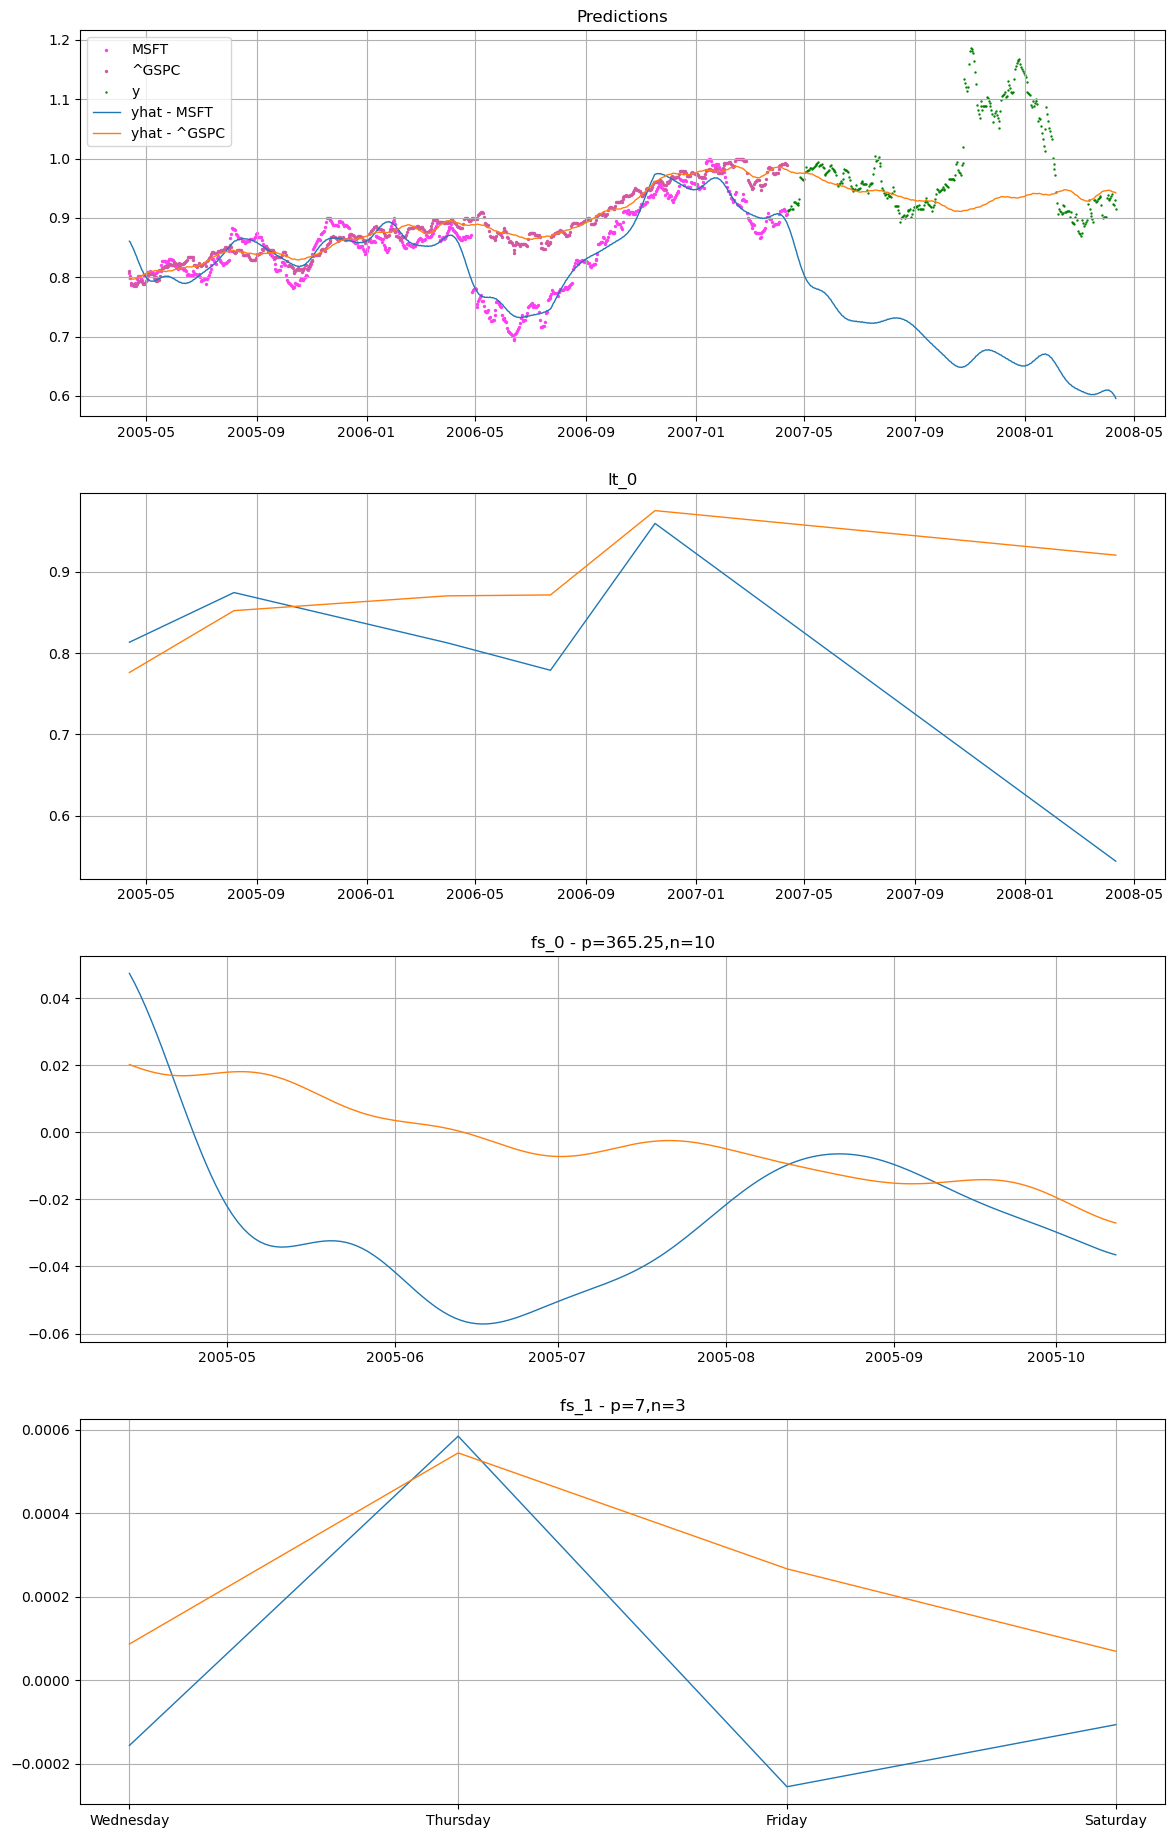

In [911]:
model.plot(yhat, y_true=test_df2["y"], pool_cols="series")

In [799]:
group, n_groups, groups_ = get_group_definition(new_model_.data, "series", "partial")
new_model_.data[group == 1]

,y,ds,series,t
0,0.641229,2008-03-19,small,0.000000
1,0.633742,2008-03-20,small,0.001372
2,0.631427,2008-03-21,small,0.002743
3,0.609728,2008-03-22,small,0.004115
4,0.623816,2008-03-23,small,0.005487
...,...,...,...,...
725,0.654035,2010-03-14,small,0.994513
726,0.668284,2010-03-15,small,0.995885
727,0.671617,2010-03-16,small,0.997257
728,0.670638,2010-03-17,small,0.998628


In [692]:
start = 100
window = 730
horizon = 365
# new_model = (LinearTrend(n_changepoints=1) + FourierSeasonality(7, 2)) * (LinearTrend(n_changepoints=5) * FourierSeasonality(365.25, 10))
new_model = LinearTrend()  + FourierSeasonality(365.25, 10)+ FourierSeasonality(7, 3)
# new_model = LinearTrend()
new_model.fit(df[start:start + window], use_prophet_initvals=False)
# preds = new_model.predict(horizon)
# preds

In [656]:
my_prophet = MyProphet()
my_prophet.fit(df[start:start + window])
my_prophet._predict_map(horizon)

,ds,t,yearly,weekly,trend,yhat
0,2008-03-19,0.000000,-0.412434,-0.034140,7.860868,7.414295
1,2008-03-20,0.001372,-0.410430,-0.085566,7.859444,7.363449
2,2008-03-21,0.002743,-0.410761,-0.075086,7.858020,7.372172
3,2008-03-22,0.004115,-0.413180,-0.264403,7.856596,7.179013
4,2008-03-23,0.005487,-0.417364,0.061939,7.855172,7.499746
...,...,...,...,...,...,...
1090,2011-03-14,1.495199,-0.472146,0.286729,9.418682,9.233265
1091,2011-03-15,1.496571,-0.456343,0.110527,9.421013,9.075198
1092,2011-03-16,1.497942,-0.442543,-0.034140,9.423345,8.946662
1093,2011-03-17,1.499314,-0.431037,-0.085566,9.425676,8.909074


In [877]:
new_model_.model

              lt_0 - slope ~ Normal(0, 5)
              lt_0 - delta ~ Laplace(0, 0.05)
          lt_0 - intercept ~ Normal(0, 5)
fs_0 - beta(p=365.25,n=10) ~ Normal(0, 10)
      fs_1 - beta(p=7,n=3) ~ Normal(0, 10)
                     sigma ~ HalfNormal(0, 0.5)
              lt_0 - trend ~ Deterministic(f(lt_0 - intercept, lt_0 - slope, lt_0 - delta))
                       obs ~ Normal(f(fs_1 - beta(p=7,n=3), fs_0 - beta(p=365.25,n=10), lt_0 - intercept, lt_0 - slope, lt_0 - delta), sigma)

In [879]:
new_model_.model.initial_point()

{'lt_0 - slope': array([0., 0., 0., 0.]),
 'lt_0 - delta': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 'lt_0 - intercept': array([0., 0., 0., 0.]),
 'fs_0 - beta(p=365.25,n=10)': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0

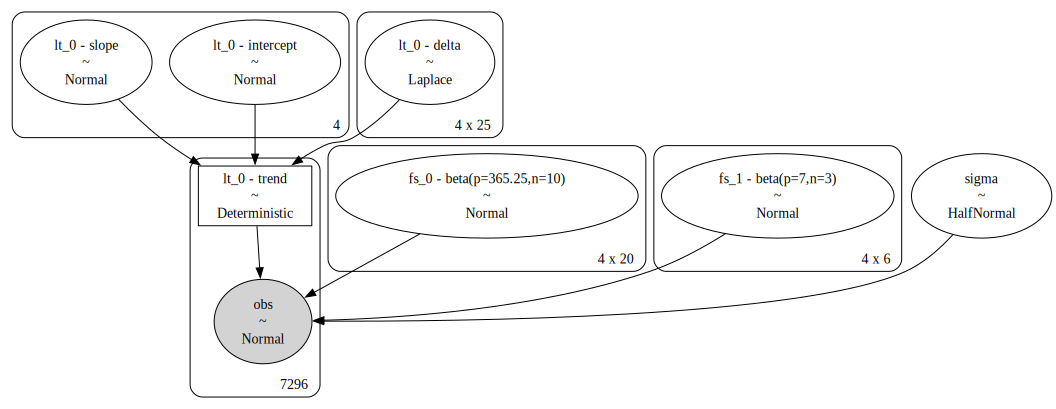

In [880]:
pm.model_to_graphviz(new_model_.model)

/home/jovan/anaconda3/envs/pymc_env/lib/python3.12/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()


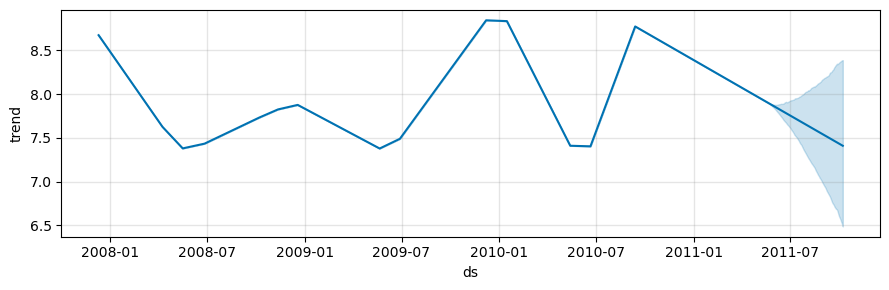

In [576]:
fig = model.plot_components(forecast)

<Axes: >

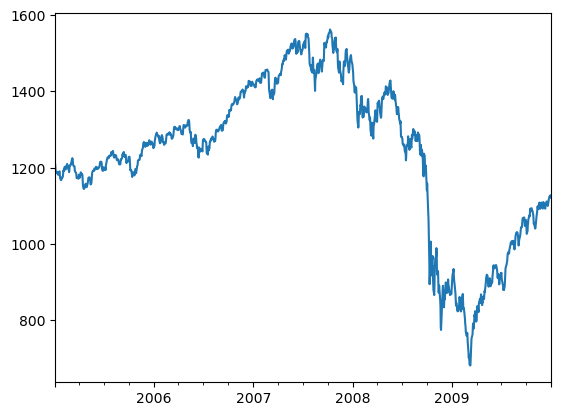

In [91]:
df["y"].plot()

In [39]:
df[df["ds"] > "2008-09-01"]

,ds,y
922,2008-09-02,1277.579956
923,2008-09-03,1274.979980
924,2008-09-04,1236.829956
925,2008-09-05,1242.310059
926,2008-09-08,1267.790039
...,...,...
1254,2009-12-24,1126.479980
1255,2009-12-28,1127.780029
1256,2009-12-29,1126.199951
1257,2009-12-30,1126.420044


<Axes: xlabel='Date'>

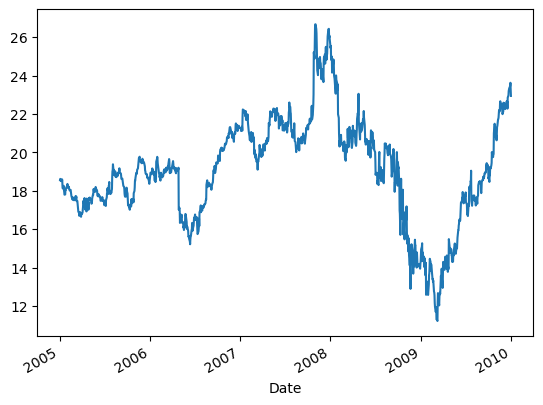

In [44]:
data["Adj Close"]["MSFT"].plot()

/tmp/ipykernel_47390/4007347958.py:193: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  date = future["ds"].dt.to_pydatetime()


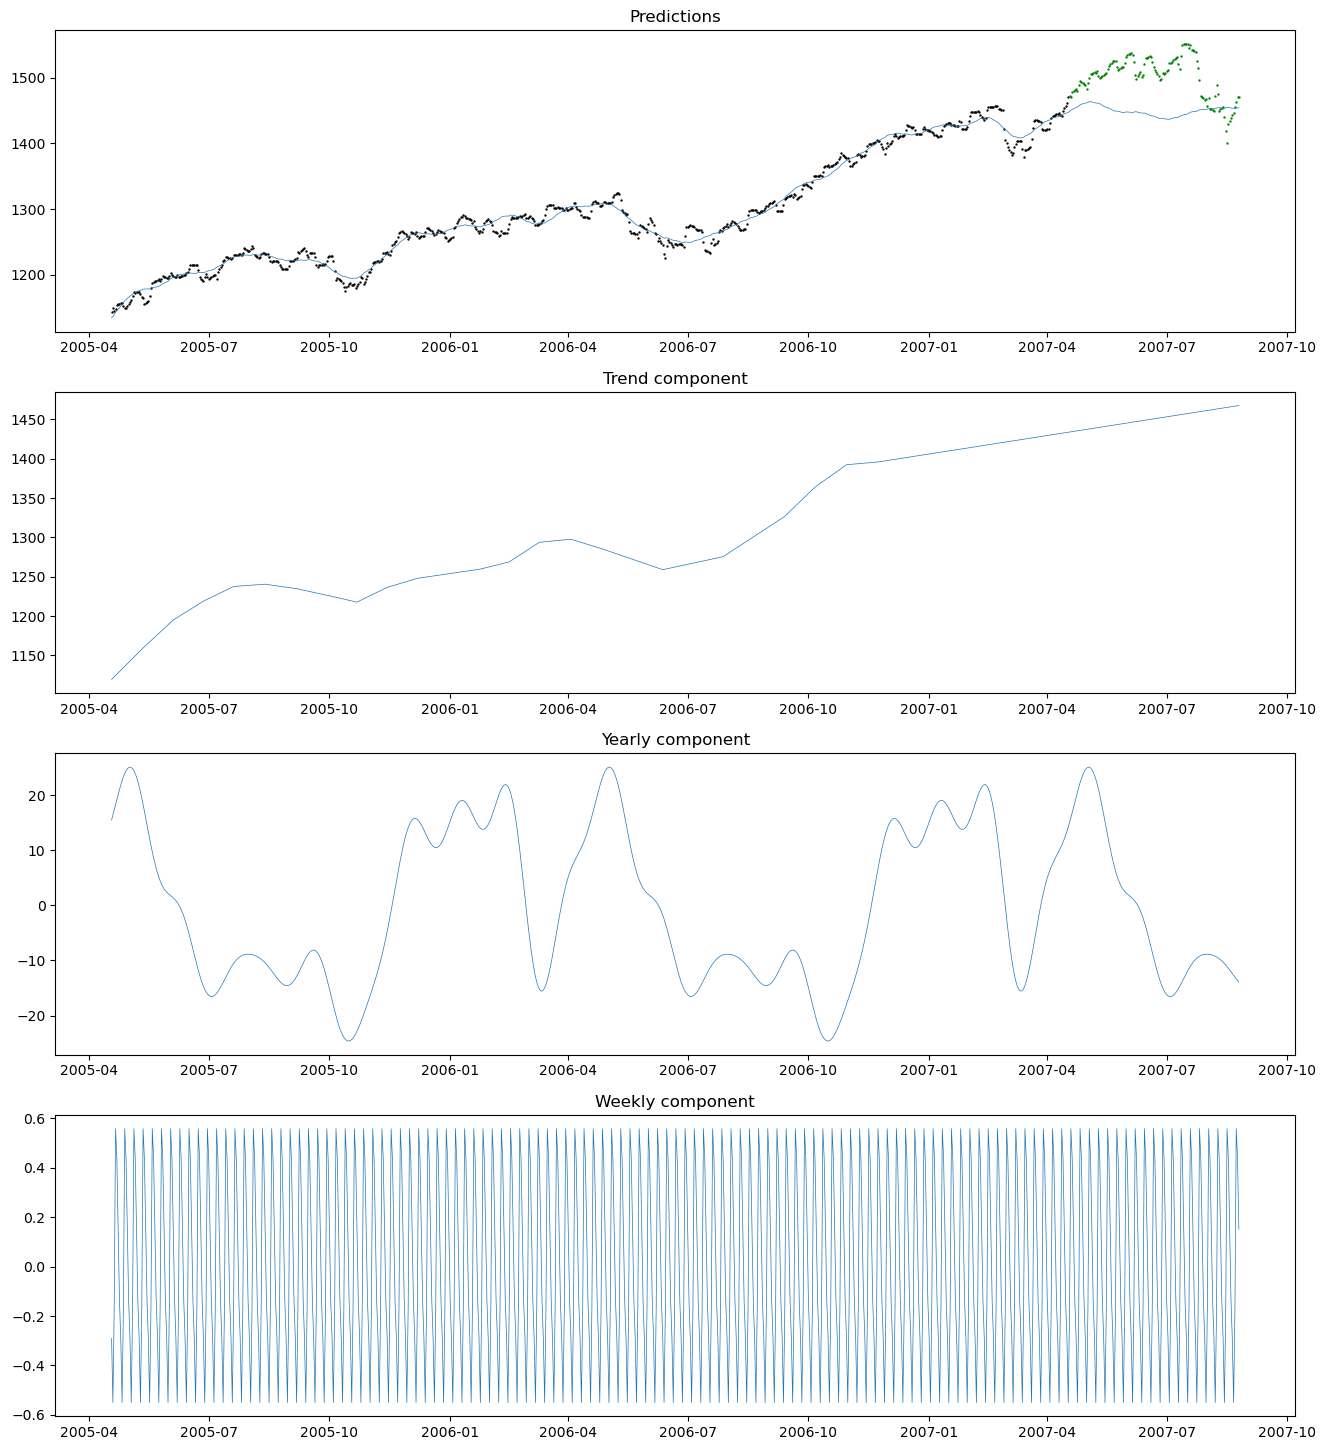

In [136]:
window = 730
horizon = 130
# start = randint(0, len(df) - window - horizon - 1)
start = 105
my_model = MyProphet()
my_model.fit(df[start:start + window])
preds = my_model._predict_map(horizon, y_true=df[start + window:start + window + horizon]["y"], plot=True)

In [144]:
new_model = LinearTrend() + FourierSeasonality(365.25, 10)
new_model.fit(df[start:start + window])

AttributeError: 'AdditiveTimeSeries' object has no attribute 'n_changepoints'

/home/jovan/anaconda3/envs/pymc_env/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/jovan/anaconda3/envs/pymc_env/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


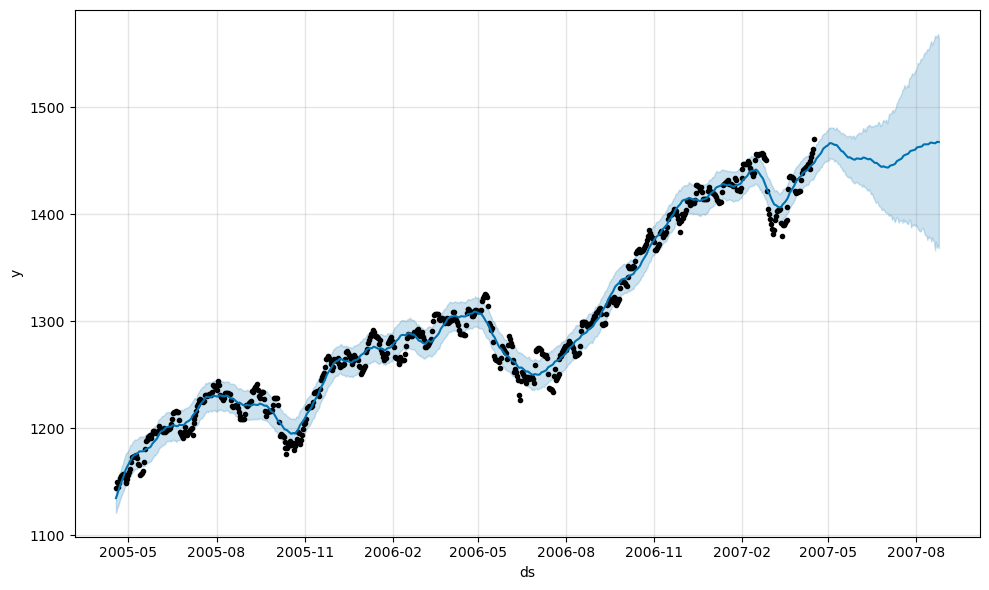

In [137]:
model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
model.fit(df[start:start + window])
future = model.make_future_dataframe(periods=horizon, include_history=True)
forecast = model.predict(future)
fig = model.plot(forecast)

In [138]:
mean_absolute_percentage_error(preds["yhat"], forecast["yhat"])

0.0010129256080573092

In [139]:
mean_absolute_percentage_error(df[start + window:start + window + horizon]["y"], preds["yhat"][window:])

0.03542767845554664

In [140]:
mean_absolute_percentage_error(df[start + window:start + window + horizon]["y"], forecast["yhat"][window:])

0.033402113292251276

/home/jovan/anaconda3/envs/pymc_env/lib/python3.12/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/jovan/anaconda3/envs/pymc_env/lib/python3.12/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/home/jovan/anaconda3/envs/pymc_env/lib/python3.12/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime o

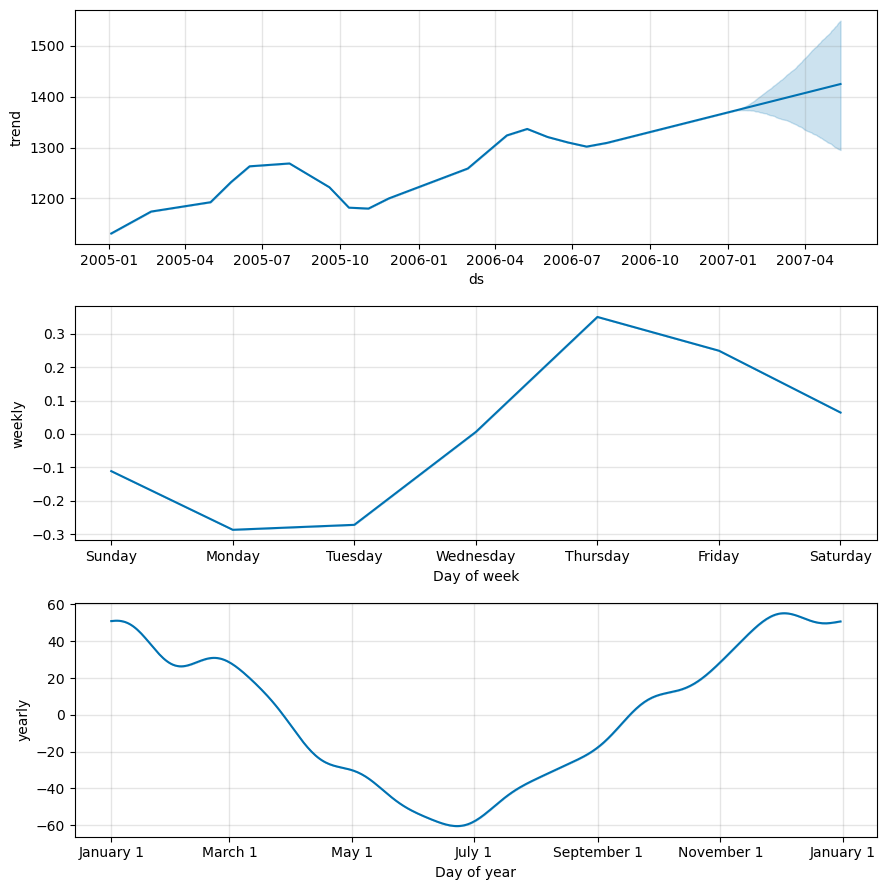

In [130]:
fig = model.plot_components(forecast)

In [104]:
df[start:start + window][["ds", "y"]]

,ds,y
576,2006-08-02,1275.572510
577,2006-08-03,1278.424988
578,2006-08-04,1281.589996
579,2006-08-05,1280.009176
580,2006-08-06,1278.428355
...,...,...
1301,2008-07-27,1249.952494
1302,2008-07-28,1246.647491
1303,2008-07-29,1249.789978
1304,2008-07-30,1274.407501
